#Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, roc_auc_score

#Leitura do CSV

In [35]:
df = pd.read_csv('Base_M43_Pratique_Hypothyroid.csv')
pd.set_option('display.max_columns', None)
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,P


###Legenda dos dados

* **age**: Idade do paciente (em anos).
* **sex**: Sexo do paciente (M = masculino, F = feminino).
* **on_thyroxine**: O paciente está tomando levotiroxina? (t = sim, f = não)
* **query_on_thyroxine**: Suspeita de uso de levotiroxina? (t = sim, f = não)
* **on_antithyroid_medication**: O paciente está em uso de medicação antitireoidiana? (t = sim, f = não)
* **sick**: O paciente está doente por alguma outra razão além da tireoide? (t = sim, f = não)
* **pregnant**: A paciente está grávida? (t = sim, f = não)
* **thyroid_surgery**: Já fez cirurgia da tireoide? (t = sim, f = não)
I131_treatment: Já recebeu tratamento com iodo radioativo (I131)? (t = sim, f = não)
* **query_hypothyroid**: Suspeita de hipotireoidismo? (t = sim, f = não)
* **query_hyperthyroid**: Suspeita de hipertireoidismo? (t = sim, f = não)
* **lithium**: Faz uso de lítio? (t = sim, f = não)
goitre: Presença de bócio (aumento da tireoide)? (t = sim, f = não)
* **tumor**: Paciente tem/tinha tumor? (t = sim, f = não)
* **hypopituitary**: Indica hipopituitarismo? (t = sim, f = não)
* **psych**: Paciente tem problemas psiquiátricos? (t = sim, f = não)
* **TSH, T3, TT4, T4U, FTI, TGB**: Valores laboratoriais dos hormônios tireoidianos.
* **TSH_measured, T3_measured, TT4_measured, T4U_measured, FTI_measured, TGB_measured,**: Indicam se cada exame laboratorial foi realizado (t = sim, f = não).
* **referral_source**: Fonte do encaminhamento (SVHC: Refere-se a “sick patient visit to health care” — pacientes encaminhados a partir de visitas a serviços de saúde. SVI: “Sick patient visit to internal medicine” — encaminhado por atendimento em Medicina Interna. SVHD: “Sick patient visit to health department” — encaminhado por departamentos de saúde pública. STMW: “Sick patient through mass workup” — paciente encaminhado por triagem em exames coletivos (screening em massa). other: Outra fonte de encaminhamento não especificada acima).
* **Class/diagnosis**: Diagnóstico final ou classificação do paciente.
* **binaryClass**: (Coluna alvo) O paciente apresenta hipotireoidismo? (P = Sim, N = Não)

#Análise dos dados

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [37]:
for coluna in df.columns:
    print(f"Valores únicos na coluna '{coluna}':")
    print(df[coluna].unique())
    print("-" * 30)

Valores únicos na coluna 'age':
['41' '23' '46' '70' '18' '59' '80' '66' '68' '84' '67' '71' '28' '65'
 '42' '63' '51' '81' '54' '55' '60' '25' '73' '34' '78' '37' '85' '26'
 '58' '64' '44' '48' '61' '35' '83' '21' '87' '53' '77' '27' '69' '74'
 '38' '76' '45' '36' '22' '43' '72' '82' '31' '39' '49' '62' '57' '1' '50'
 '30' '29' '75' '19' '7' '79' '17' '24' '15' '32' '47' '16' '52' '33' '13'
 '10' '89' '56' '20' '90' '40' '88' '14' '86' '94' '12' '4' '11' '8' '5'
 '455' '2' '91' '6' '?' '93' '92']
------------------------------
Valores únicos na coluna 'sex':
['F' 'M' '?']
------------------------------
Valores únicos na coluna 'on thyroxine':
['f' 't']
------------------------------
Valores únicos na coluna 'query on thyroxine':
['f' 't']
------------------------------
Valores únicos na coluna 'on antithyroid medication':
['f' 't']
------------------------------
Valores únicos na coluna 'sick':
['f' 't']
------------------------------
Valores únicos na coluna 'pregnant':
['f' 't']
---

#Pré processamento

Analisando o dataframe, nota-se muitas colunas (30). Outra observação é de que essa tabela não apresenta nulos a princípio, mas analisando os valores unicos podemos identificar valores não úteis que deveriam estar classificados como nulos mas estão como uma string '?'. Dessa forma, esses valores foram substituidos por nulos para facilitar a limpeza dos dados.

In [38]:
df = df.replace('?', np.nan)
df = df.dropna(subset=['sex'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3622 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3621 non-null   object 
 1   sex                        3622 non-null   object 
 2   on thyroxine               3622 non-null   object 
 3   query on thyroxine         3622 non-null   object 
 4   on antithyroid medication  3622 non-null   object 
 5   sick                       3622 non-null   object 
 6   pregnant                   3622 non-null   object 
 7   thyroid surgery            3622 non-null   object 
 8   I131 treatment             3622 non-null   object 
 9   query hypothyroid          3622 non-null   object 
 10  query hyperthyroid         3622 non-null   object 
 11  lithium                    3622 non-null   object 
 12  goitre                     3622 non-null   object 
 13  tumor                      3622 non-null   object 
 1

/tmp/ipython-input-387102495.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('?', np.nan)


In [39]:
df['age'] = pd.to_numeric(df['age'], errors='coerce').astype('Int64')
df['TSH'] = df['TSH'].astype(float)
df['T3'] = df['T3'].astype(float)
df['TT4'] = df['TT4'].astype(float)
df['T4U'] = df['T4U'].astype(float)
df['FTI'] = df['FTI'].astype(float)
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3621.0,3270.000000,2877.000000,3405.000000,3255.000000,3257.000000,0.0
mean,51.840099,5.004784,2.010650,108.204347,0.995516,110.272981,NaN
std,20.094311,23.603386,0.828999,35.604462,0.195374,32.864116,NaN
min,1.0,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.0,0.490000,1.600000,87.000000,0.880000,93.000000,NaN
50%,54.0,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.0,2.700000,2.300000,124.000000,1.080000,124.000000,NaN
max,455.0,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


As colunas que deveriam ser numéricas estavam como objeto. Para usar o modelo de previsão é necessário que todas sejam transformadas em numéricas e isso foi realizado no bloco acima.

#Análise exploratória

Foi feita uma breve análise exploratória para identificar o balanceamento da variável alvo e da variável 'referral source', de encaminhamento dos pacientes.

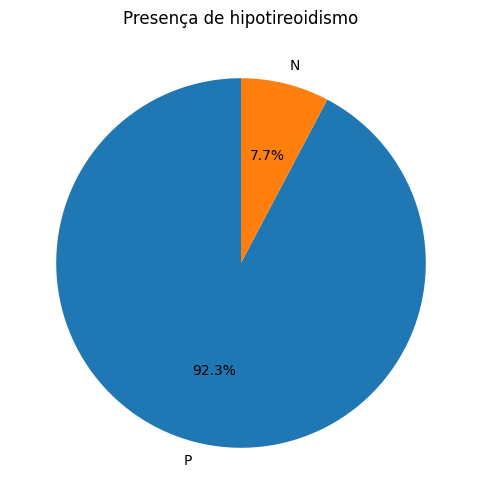

In [40]:
plt.figure(figsize=(10,6))

contagem = df['binaryClass'].value_counts()
plt.pie(contagem, startangle=90, labels=contagem.index, autopct='%1.1f%%')
plt.title('Presença de hipotireoidismo')

plt.show()

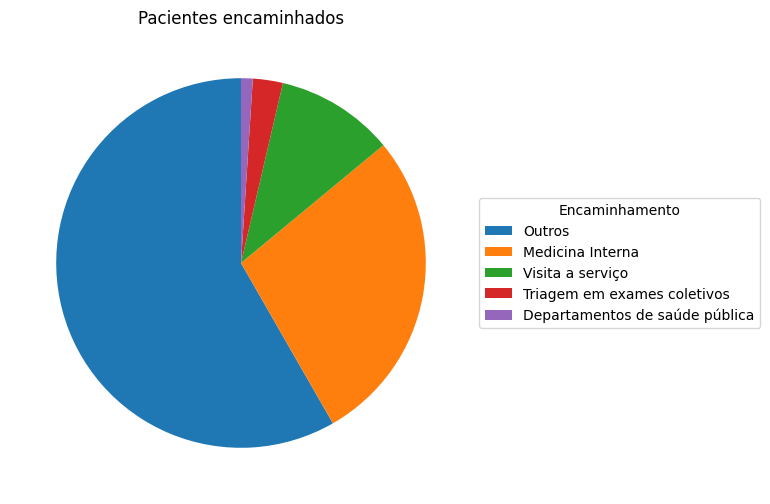

In [41]:
plt.figure(figsize=(10,6))

mapeamento = {
    'SVHC': 'Visita a serviço',
    'SVI': 'Medicina Interna',
    'SVHD': 'Departamentos de saúde pública',
    'STMW': 'Triagem em exames coletivos',
    'other': 'Outros'
}

counts = df['referral source'].value_counts()
labels = [mapeamento.get(val, 'Desconhecido') for val in counts.index]
wedges, texts = plt.pie(counts, startangle=90)

plt.legend(wedges, labels, title='Encaminhamento', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Pacientes encaminhados')
plt.show()

#Divisão em treino e teste

In [42]:
X = df.drop('binaryClass', axis=1)
y = df['binaryClass']
y = y.map({'N': 0, 'P': 1})

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Construção da Pipeline

In [44]:
pre = ColumnTransformer([
  ('drop_cols', 'drop', ['TBG measured','TBG']),
  ('num', SimpleImputer(strategy='median'), ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']),
  ('cat', OneHotEncoder(handle_unknown='ignore'), ['on thyroxine',
                                                   'query on thyroxine',
                                                   'on antithyroid medication',
                                                   'sick',
                                                   'pregnant',
                                                   'thyroid surgery',
                                                   'I131 treatment',
                                                   'query hypothyroid',
                                                   'query hyperthyroid',
                                                   'lithium',
                                                   'goitre',
                                                   'tumor',
                                                   'hypopituitary',
                                                   'psych',
                                                   'TSH measured',
                                                   'T3 measured',
                                                   'TT4 measured',
                                                   'T4U measured',
                                                   'FTI measured',
                                                   'referral source'])
])

In [45]:
pipe = Pipeline([
  ('prep', pre),
  ('scaler', StandardScaler(with_mean=False)),
  ('smote', SMOTE()),
  ('pca', PCA(n_components=19)),
  ('clf', XGBClassifier())
])


In [46]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('drop_cols', 'drop',
                                                  ['TBG measured', 'TBG']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'TSH', 'T3', 'TT4',
                                                   'T4U', 'FTI']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['on thyroxine',
                                                   'query on thyroxine',
                                                   'on antithyroid medication',
                                                   'sick', 'pregnant',
                                                   'thyroid surgery',
                                                   'I131 treatment',
                                                   'query hypothyroi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [47]:
pca = pipe.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = pca.explained_variance_ratio_.cumsum()

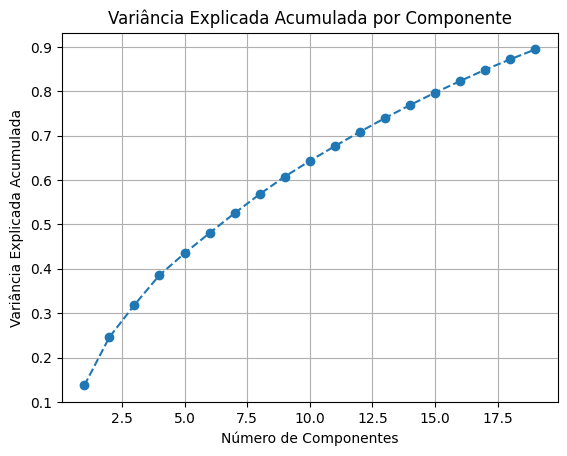

In [48]:
plt.plot(range(1, 20), cumulative_variance, marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada por Componente')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

Para evitar *data leak* e organizar melhor o pré processamento e treinamento, foi criado um pipeline. para ajustar melhor o PCA, o modelo foi treinado brevemente apenas para identificar quantas variáveis seriam responsáveis por explicar 90% da variância. Esse valor, conforme mostrado no gráfico acima foi de 19.
No pré processamento dos dados, as colunas 'TBG measured','TBG' foram removidas do X pois possuiam apenas valores nulos. Depois, nas colunas numéricas, todos os valores nulos foram substituidos pela mediana da coluna. Já as colunas categóricas restantes, foram codificadas usando o One Hot Encoder.
Depois, a pipeline foi criada executando, na ordem: o pré processamento, a padronização, o balanceamento, o PCA (usando apenas as 19 melhores variáveis) e a criação do modelo XGBoost.

#Treinamento

In [49]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

O modelo foi treinado usando a GridSearchCV, testando os seguintes hyperparâmetros: n_estimators, max_depth, learning_rate, subsample, colsample, bytree. O treino foi feito buscando a melhor acurácia.

#Avaliação

In [53]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print("ROC-AUC:", roc_auc)
print('Relatório de Classificação:')
print(report)

Acurácia: 0.9724137931034482
ROC-AUC: 0.8845752532193211
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82        59
           1       0.98      0.99      0.99       666

    accuracy                           0.97       725
   macro avg       0.92      0.88      0.90       725
weighted avg       0.97      0.97      0.97       725



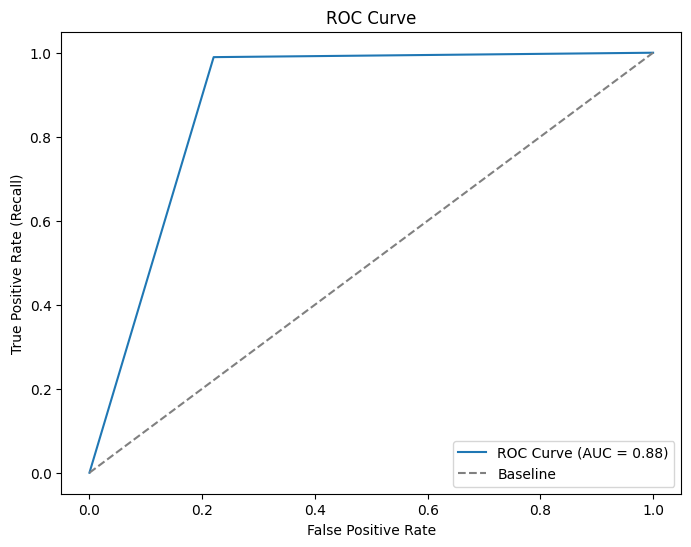

In [54]:
plt.figure(figsize=(8,6))

# ---- Curva ROC ----
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")

# ---- Linha diagonal (baseline) ----
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Baseline")

# ---- Área preenchida entre curva ROC e diagonal ----
plt.fill_between(fpr, tpr, fpr, where=(tpr > fpr), alpha=0.3)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

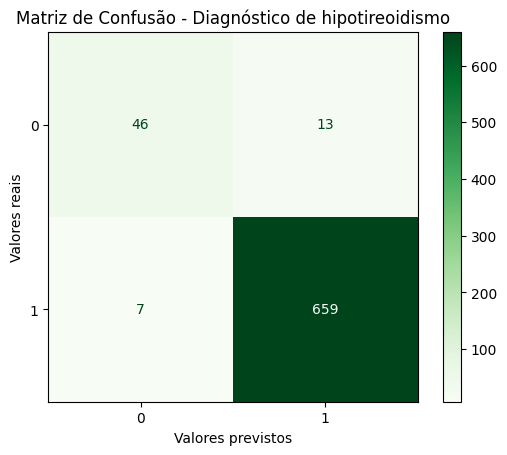

In [52]:
cm_logis = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logis, display_labels=[0, 1])
disp.plot(cmap="Greens")
plt.title("Matriz de Confusão - Diagnóstico de hipotireoidismo")
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()

O modelo apresenta acurácia e recall excelentes para identificar pacientes com hipotireoidismo e apresenta metricas inferiores mas ainda assim muito boas para identificar pacientes sem a doença. Apresenta uma boa curva ROC, demonstrando que a quantidade de falso positivos está baixa. E na matriz de confusão, mostra que o modelo acertou quase todos os casos da doença, mas teve uma precisão menor nos casos em que o paciente não possuia hipotireodismo. no geral o modelo apresentou uma excelente performace.